# Time Domain Simphony Ideal Models

This notebook compares the ideal models in the Time Domain Simphony library to Simphonies frequency domain models

Presently, the following ideal models are available in the Time Domain Simphony library:  
time_domain.ideal.coupler  
time_domain.ideal.waveguide  

which corresponse to the following frequency domain models:  
libraries.ideal.coupler  
libraries.ideal.waveguide  

In [1]:
from simphony.libraries.ideal import coupler, waveguide
from simphony.time_domain.ideal import TimeCoupler, TimeWaveguide,TimePhase_Modulator # import td.coupler and td.waveguide
from simphony.time_domain.time_circuit import TimeCircuit

# Coupler
`libraries.ideal.coupler` is a function which calculates the s-parameters for an ideal coupler. The Time Domain Coupler model is not a function, but a class which can be used to simulate a coupler in a time domain simulation.

In [2]:
print(f"Frequency-Domain Waveguide Model: {coupler}")
print(f"Time-Domain Waveguide Model: {TimeCoupler}")

Frequency-Domain Waveguide Model: <function coupler at 0x7f840bc9a0c0>
Time-Domain Waveguide Model: <class 'simphony.time_domain.ideal.TimeCoupler'>


There are three parameters in the frequency domain coupler model:

- `coupling` - The coupling ratio of the coupler. This is the ratio of the power in the through port to the power in the coupled port.
- `loss` - The loss in the coupler. This is the ratio of the power in the input port to the power in the through port.
- `phi` - The phase difference between the through and coupled ports.

In [2]:
import jax.numpy as jnp
from simphony.utils import dict_to_matrix
import matplotlib.pyplot as plt

coupling = 0.5
loss = 0.0
phi = jnp.pi/2

coupler_fd = coupler(coupling=coupling, loss=loss, phi=phi)
coupler_sparams = dict_to_matrix(coupler_fd)

print(f"Shape of the resulting matrix: {coupler_sparams.shape}")
print(f"S-Params: {coupler_sparams}")



An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Shape of the resulting matrix: (1, 4, 4)
S-Params: [[[0.00000000e+00+0.j         7.07106781e-01+0.j
   0.00000000e+00+0.j         4.32978028e-17+0.70710678j]
  [7.07106781e-01+0.j         0.00000000e+00+0.j
   4.32978028e-17+0.70710678j 0.00000000e+00+0.j        ]
  [0.00000000e+00+0.j         4.32978028e-17+0.70710678j
   0.00000000e+00+0.j         7.07106781e-01+0.j        ]
  [4.32978028e-17+0.70710678j 0.00000000e+00+0.j
   7.07106781e-01+0.j         0.00000000e+00+0.j        ]]]


The time domain model uses these same parameters, but it does not return anything when instantiated. Instead, the time domain model itself is a subclass of `TimeSystem` which can be used in a time domain simulations.

In [3]:
coupler_td = TimeCoupler(coupling=coupling, loss=loss, phi=phi)

The most import method in `td.coupler` is the `response()` method which calculates the system response for an arbitrary input signal. Since the coupler is a 4-port device, the input signal must be a 4xN numpy array, where N is the number of time steps in the simulation.

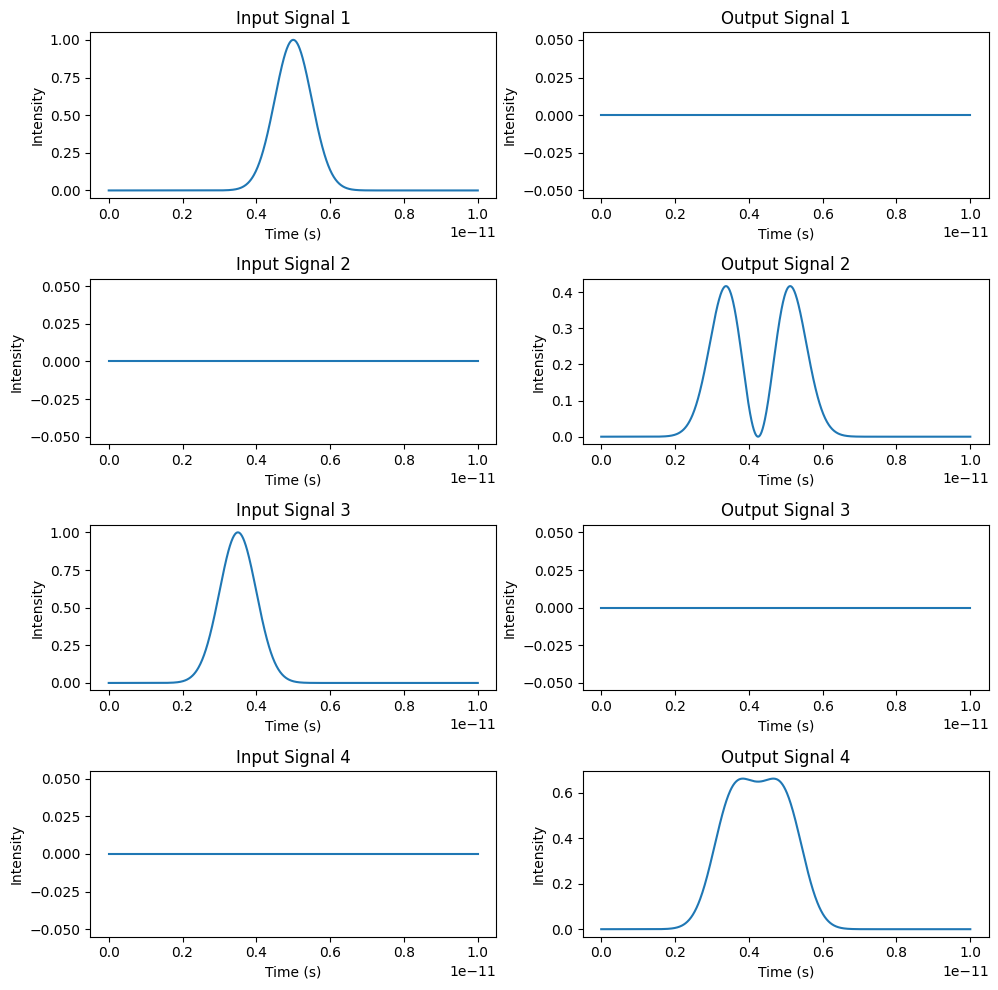

In [4]:
from simphony.time_domain.utils import gaussian_pulse
T = 10e-12
N = 1000
t = jnp.linspace(0, T, N)

t0 = T/2
std = 1e-12

inputs = {
    'o0': gaussian_pulse(t, t0, std),
    'o1': jnp.zeros((N), dtype=complex),
    'o2': 1j*gaussian_pulse(t, t0 - 0.3 * t0, std),
    'o3': jnp.zeros((N), dtype=complex),
}

outputs = coupler_td.response(inputs)

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(10, 10))  # 4 rows, 2 columns

# Plot input signals
for i in range(4):
    axs[i, 0].plot(t, jnp.abs(inputs[f'o{i}'])**2)
    axs[i, 0].set_title(f'Input Signal {i+1}')
    axs[i, 0].set_xlabel('Time (s)')
    axs[i, 0].set_ylabel('Intensity')

# Plot output signals
for i in range(4):
    axs[i, 1].plot(t, jnp.abs(outputs[f'o{i}'])**2)
    axs[i, 1].set_title(f'Output Signal {i+1}')
    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylabel('Intensity')

# Adjust layout
plt.tight_layout()
plt.show()

# Waveguide

Similar to the coupler, the ideal waveguide model in the Time Domain is a class and not a function as it is in simphony's frequency domain library. 

In [19]:
print(f"Frequency-Domain Waveguide Model: {waveguide}")
print(f"Time-Domain Waveguide Model: {TimeWaveguide}")

Frequency-Domain Waveguide Model: <function waveguide at 0x7f7c1c93eb60>
Time-Domain Waveguide Model: <class 'simphony.time_domain.ideal.TimeWaveguide'>


There are 6 parameters in the frequency domain waveguide model:
- `wavelength (wl)`
- `center wavelength (wl0)`
- `effective index (neff)`
- `group index (ng)`
- `length`
- `loss`

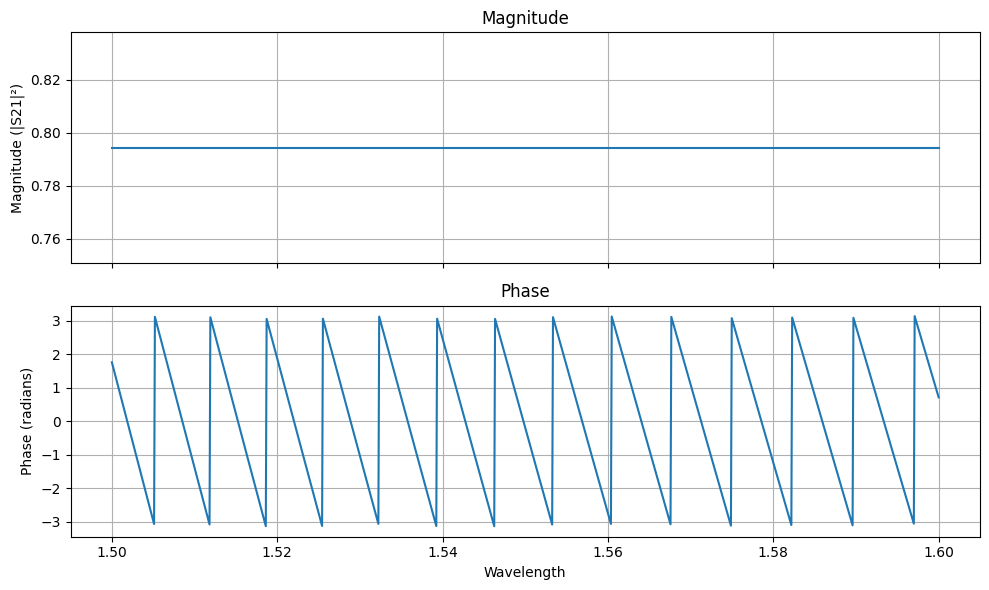

In [20]:
# Demonstrate the Spectra Calculated from fd.waveguide
wl = jnp.linspace(1.5, 1.6, 1000)
wl0 = 1.55
neff = 2.34
ng = 3.4
length = 100.0
loss = 100.0

waveguide_fd = waveguide(wl = wl, wl0=wl0, neff=neff, ng=ng, length=length, loss=loss)
waveguide_sparams = dict_to_matrix(waveguide_fd)

# plt.plot(jnp.abs(waveguide_sparams[:, 0, 1])**2)
# plt.plot(jnp.angle(waveguide_sparams[:, 0, 1]))
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Magnitude subplot
axs[0].plot(wl, jnp.abs(waveguide_sparams[:, 0, 1])**2)
axs[0].set_title('Magnitude')
axs[0].set_ylabel('Magnitude (|S21|²)')
axs[0].grid()

# Phase subplot
axs[1].plot(wl, jnp.angle(waveguide_sparams[:, 0, 1]))
axs[1].set_title('Phase')
axs[1].set_ylabel('Phase (radians)')
axs[1].set_xlabel('Wavelength')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

In the time domain model, the first parameter which specifies the wavelength is not needed. Instead, the waveguide model needs to know the time step of the simulation. This is because the waveguide model mantains its state by implementing a queue, where each element of the queue is the signal at a different time step.
- `time step (dt)`
- `center wavelength (wl0)`
- `effective index (neff)`
- `group index (ng)`
- `length`
- `loss`

The time-domain waveguide model must keep track of the state of the waveguide to properly calculate transient effects brought by the non-finite length of the waveguide. This state is maintained across multiple calls to the `response()` method.

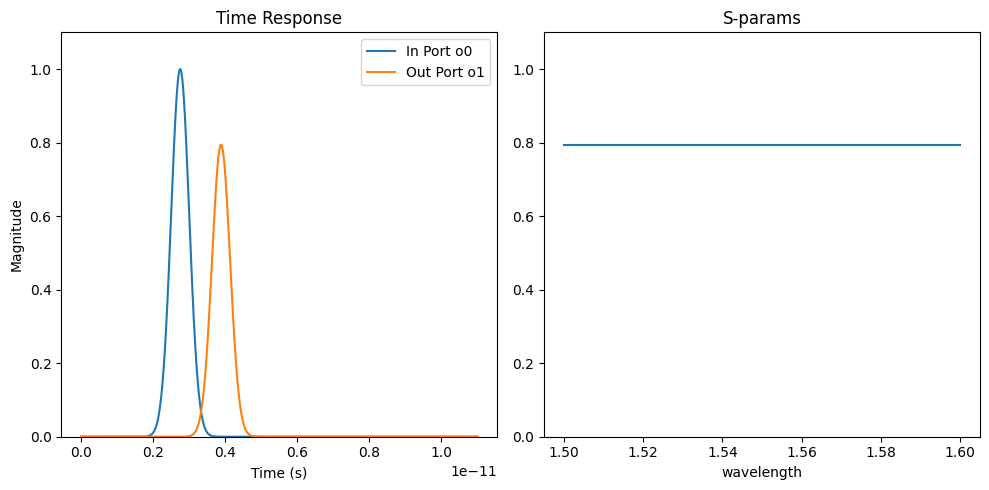

In [12]:
# Demonstrate the use of the waveguide response function
from simphony.time_domain.utils import gaussian_pulse
T = 11e-12
N = 1000
t = jnp.linspace(0, T, N)
dt = t[1] - t[0]

t0 = T/2
std = 0.5e-12

waveguide_td = TimeWaveguide(dt, wl0=wl0, neff=neff, ng=ng, length=length, loss=loss)

inputs = {
    'o0': gaussian_pulse(t, t0 - 0.5*t0, std),
    'o1': 0.5*gaussian_pulse(t, t0 - 0.25*t0, std),
}

outputs = waveguide_td.response(inputs)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 4 rows, 2 columns

# Plot input signals
axs[0].plot(t, jnp.abs(inputs['o0'])**2, label=f'In Port o0')
axs[0].plot(t, jnp.abs(outputs['o1'])**2, label=f'Out Port o1')
axs[0].set_title('Time Response')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Intensity')
axs[0].set_ylim(0.0, 1.1)
axs[0].legend()

# Plot output signals
axs[1].plot(wl, jnp.abs(waveguide_sparams[:, 0, 1])**2)
axs[1].set_title(f'S-params')
axs[1].set_xlabel('wavelength')
axs[0].set_ylabel('Magnitude')
axs[1].set_ylim(0.0, 1.1)

# Adjust layout
plt.tight_layout()
plt.show()

# Ring Resonator Example

Unlike the sax.circuit function in the frequency domain, the `TimeCircuit` object is a class which whose models are class types (subcalsses of `TimeSystem`). Instead of calling the simulation object directly as was done in the frequency domain, we must instantiate the time system models with the `TimeCircuit.instantiate` method.

The ideal models may be instantiated by setting individual parameters in a dictionary (similar to the frequency domain) or by providing an previously initialized class.

In [ ]:
# Use simulation.py to implement a ring resonator using only td.ideal components
ring_resonator = TimeCircuit(
    netlist={
        "instances": {
            "coupler": "ideal_coupler",
            "ring": "ideal_waveguide",
        },
        "connections": {
            "coupler,o3": "ring,o0",
            "ring,o1": "coupler,o2",
        },
        "ports": {
            "in": "coupler,o0",
            "out": "coupler,o1",
        },
    },
    models={
        "ideal_coupler": TimeCoupler,
        "ideal_waveguide": TimeWaveguide
        "mzi1": StateSpaceDiscrete,
        # "mzi2": StateSpaceContinuous
    },
)


There are 2 main advantageous to providing previously initialized classes
 
1) The `TimeCircuit` class is that it can be turned into a TimeSystem model with the method `TimeCircuit.to_time_system` for a modular design.
2) The `TimeSystem` classes instantiated by the PoleResidueModel can be used directly

The main advantage of using a dictionary to instanstiate the models in the `TimeCircuit` is it very closely parallels the method used in frequency domain simphony.

Both methods are shown below:

In [8]:
wl0 = 1.55
neff = 2.34
ng = 3.4
length = 100.0
loss = 100.0
waveguide_td = TimeWaveguide(dt, wl0=wl0, neff=neff, ng=ng, length=length, loss=loss)

# ring_resonator.instantiate(dt=1e-14, 
#                            ideal_coupler={"coupling": 0.5, "loss": 0.0, "phi": jnp.pi/2}, 
#                            ideal_waveguide={"wl0": 1.55, "neff": 3.4, "ng": 3.4, "length": 100.0, "loss": 100.0})
ring_resonator.instantiate(dt=1e-14, ideal_coupler=coupler_td, ideal_waveguide=waveguide_td)

Instances created with dt=1e-14: {'coupler': <simphony.time_domain.ideal.TimeCoupler object at 0x7f8aa4698d50>, 'ring': <simphony.time_domain.ideal.TimeWaveguide object at 0x7f8aa466cd50>}


In [9]:
# waveguide_td = TimeWaveguide(dt, wl0=wl0, neff=neff, ng=ng, length=length, loss=loss)
T = 11e-12
N = 1000
t = jnp.linspace(0, T, N)
dt = t[1] - t[0]

t0 = T/2
std = 0.5e-12

inputs = {
    'in': gaussian_pulse(t, t0 - 0.5*t0, std),
    'out': jnp.zeros_like(t),
}

outputs = ring_resonator.run_sim(t, inputs)

Looking in Circuit Ports
Looking in Circuit Ports
Looking in connections
Looking in connections
Looking in connections
Looking in connections
Looking in Circuit Ports
Looking in Circuit Ports
Looking in connections
Looking in connections
Looking in connections
Looking in connections
Looking in Circuit Ports
Looking in Circuit Ports
Looking in connections
Looking in connections
Looking in connections
Looking in connections
Looking in Circuit Ports
Looking in Circuit Ports
Looking in connections
Looking in connections
Looking in connections
Looking in connections
Looking in Circuit Ports
Looking in Circuit Ports
Looking in connections
Looking in connections
Looking in connections
Looking in connections
Looking in Circuit Ports
Looking in Circuit Ports
Looking in connections
Looking in connections
Looking in connections
Looking in connections
Looking in Circuit Ports
Looking in Circuit Ports
Looking in connections
Looking in connections
Looking in connections
Looking in connections
Lookin

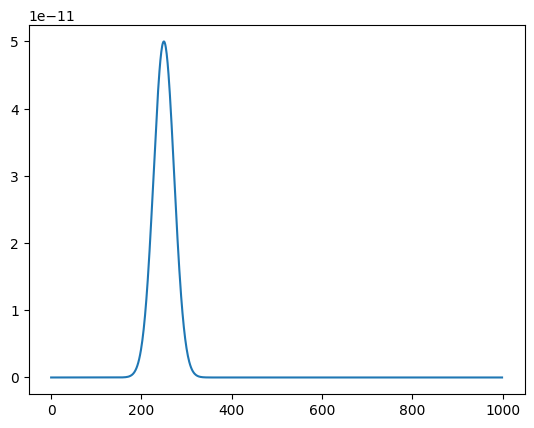

In [10]:
plt.plot(jnp.abs(outputs['out'])**2)

In [5]:
# Use simulation.py to implement a ring resonator using only td.ideal components
ring_resonator_with_phase_modulator = TimeCircuit(
    netlist={
        "instances": {
            "coupler": "ideal_coupler",
            "ring": "ideal_waveguide",
            "pmod": "ideal_modulator",
        },
        "connections": {
            "coupler,o3": "pmod,o0",
            "pmod,o1":"ring, o0",
            "ring,o1": "coupler,o2",
        },
        "ports": {
            "in": "coupler,o0",
            "out": "coupler,o1",
        },
    },
    models={
        "ideal_coupler": TimeCoupler,
        "ideal_waveguide": TimeWaveguide,
        "ideal_modulator": TimePhase_Modulator,
        # "mzi1": StateSpaceDiscrete,
        # "mzi2": StateSpaceContinuous
    },
)
wl0 = 1.55
neff = 2.34
ng = 3.4
length = 100.0
loss = 100.0
T = 11e-12
N = 1000
t = jnp.linspace(0, T, N)
dt = t[1] - t[0]
t0 = T/2
std = 0.5e-12
f_mod = 20e6
m = jnp.sin(2 * jnp.pi * f_mod * t)
waveguide_td = TimeWaveguide(dt, wl0=wl0, neff=neff, ng=ng, length=length, loss=loss)
coupler_td = TimeCoupler(coupling=coupling, loss=loss, phi=phi)
phase_mod_td = TimePhase_Modulator(mod_signal = m, k_p = 1)

inputs = {
    'in': gaussian_pulse(t, t0 - 0.5*t0, std),
    'out': jnp.zeros_like(t),
}


ring_resonator_with_phase_modulator.instantiate(dt=1e-14, ideal_coupler=coupler_td, ideal_waveguide=waveguide_td, ideal_modulator=phase_mod_td)
outputs = ring_resonator_with_phase_modulator.run_sim(t, inputs)

Instances created with dt=1e-14: {'coupler': <simphony.time_domain.ideal.TimeCoupler object at 0x7f68982f63d0>, 'ring': <simphony.time_domain.ideal.TimeWaveguide object at 0x7f68982c33d0>, 'pmod': <simphony.time_domain.ideal.TimePhase_Modulator object at 0x7f68bc6cb850>}
Looking in Circuit Ports
Looking in Circuit Ports
Looking in connections
Looking in connections
Looking in connections
Looking in connections
Looking in connections
Looking in connections


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html